In [1]:
import sys
from pathlib import Path
import importlib
import math

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm


sys.path.insert(0, str(Path("../..").resolve()))
from curves import CubicSpline

# Local modules
#import gm_utils
#importlib.reload(gm_utils)  
#from gm_utils import visualize_density, sample, geodesic, energy
#from curves import CubicSpline

# Matplotlib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

# 2D EXPERIMENTS


In [3]:
def gaussian_mixture_density(x, t):
    """
    Analytical marginal log-density for 2D Gaussian mixture.
    x: (B, 2)
    t: (B,)
    """
    alpha_t, sigma_t = alpha_sigma(t)           
    
    means_t = alpha_t[:, None, None] * original_means[None, :, :]  
    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance  

    # Compute log probability for each component
    diff = x[:, None, :] - means_t  
    log_gauss = -0.5 * (torch.log(2 * torch.pi * variances_t[:, :, None]) + (diff**2).sum(dim=2)/variances_t[:, :, None]) 
    log_gauss = log_gauss.squeeze(-1)  

    log_probs = torch.log(weights[None, :]) + log_gauss  
    log_p_t = torch.logsumexp(log_probs, dim=1)  # (B,)
    return log_p_t

'''

def compute_vector_field(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    x: (B, D)
    t: (B,)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]  

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = -sigma_t**2 * dlambda_dt  

    log_p_t = gaussian_mixture_density(x, t)  
    grad_log_p_t = torch.autograd.grad(
        log_p_t.sum(), x, create_graph=True
    )[0]  

    dx = f_t[:, None] * x - 0.5 * g2_t[:, None] * grad_log_p_t  
    dt = -torch.ones_like(t)  # (B,)

    return dt, dx



def sample(x, n_steps, t_start=1.0, t_end=0.0):
    B, D = x.shape
    t = t_start * torch.ones(B, dtype=x.dtype, device=x.device)
    dt_val = (t_start - t_end) / n_steps

    all_x = [x.detach().cpu().numpy()]
    all_t = [t.detach().cpu().numpy()]

    for _ in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        x = x + dx * dt_val
        t = t + dt * dt_val

        all_x.append(x.detach().cpu().numpy())
        all_t.append(t.detach().cpu().numpy())

    return np.array(all_t), np.array(all_x)
'''

def compute_vector_field(x, t):
    """
    Probability Flow ODE vector field
    x: (B, D)
    t: (B,)
    returns dx/dt: (B, D)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]  # (B,)

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = -sigma_t**2 * dlambda_dt  # (B,)

    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(
        log_p_t.sum(), x, create_graph=True
    )[0]  # (B, D)

    dx = f_t[:, None] * x - 0.5 * g2_t[:, None] * grad_log_p_t
    return dx

def sample(x0, n_steps, t_start=1.0, t_end=0.0):
    B, D = x0.shape
    x = x0.clone()
    t = t_start * torch.ones_like(torch.tensor([1]))

    #t = t_start * torch.ones(B, device=x.device)

    dt = (t_end - t_start) / n_steps  # negative

    all_x = [x.detach().cpu().numpy()]
    all_t = [t.detach().cpu().numpy()]

    for _ in range(n_steps):
        dx = compute_vector_field(x, t)
        x = x + dx * dt
        t = t + dt

        all_x.append(x.detach().cpu().numpy())
        all_t.append(t.detach().cpu().numpy())

    print('all_t', all_t[0], 'all_x', all_x[0])
    return np.array(all_t), np.array(all_x)


def eds(t, x):
    """
    Expected Denoised Sample (EDS) for 2D spatial data
    Args:
        t: (B,) tensor of time values
        x: (B, 2) tensor of spatial values
    Returns:
        res: (B, 2) denoised mean
    """
    assert t.ndim == 1 and x.ndim == 2 and x.shape[0] == t.shape[0]

    alpha_t, sigma_t = alpha_sigma(t)
    x = x.clone().requires_grad_(True)
    
    # Compute score
    log_p_t = gaussian_mixture_density(x, t)  
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    # Tweedie formula
    res = (x + sigma_t[:, None]**2 * grad_log_p_t) / alpha_t[:, None]
    return res


def mu(theta):
    """
    Expectation parameter for 2D spatial data
    Args:
        theta: (B, 3) tensor where columns = [t, x1, x2]
    Returns:
        mu_t: (B,) tensor
        mu_x: (B, 2) tensor
    """
    t = theta[:, 0]
    x = theta[:, 1:]  # shape (B, 2)
    
    alpha_t, sigma_t = alpha_sigma(t)
    f = eds(t, x)  # shape (B, 2)
    
    div = torch.zeros(t.shape, device=x.device)
    for d in range(x.shape[1]):  # 2D
        div += torch.autograd.grad(f[:, d].sum(), x, create_graph=True)[0][:, d]
    
    mu_t = sigma_t**2 / alpha_t * div + (f**2).sum(dim=1)  
    mu_x = f  # (B, 2)
    return mu_t, mu_x

def eta(theta):
    """
    Natural parameter for 2D spatial data
    Args:
        theta: (B, 3) tensor where columns = [t, x1, x2]
    Returns:
        eta_t: (B,) tensor
        eta_x: (B, 2) tensor
    """
    t = theta[:, 0]
    x = theta[:, 1:] 
    
    alpha_t, sigma_t = alpha_sigma(t)
    
    eta_t = -0.5 * (alpha_t**2 / sigma_t**2)
    eta_x = (alpha_t / sigma_t**2)[:, None] * x
    return eta_t, eta_x



def energy(theta):
    """
    Discretized curve energy (Eq. 23), identical procedure to compute_batch_energy.

    theta : (N, 3) tensor
        Columns are [t, x1, x2]
    """


    mu_t, mu_x = mu(theta)       # (N,), (N, 2)
    eta_t, eta_x = eta(theta) 

    deta_t = eta_t[1:] - eta_t[:-1]    # (N-1,)
    dmu_t  = mu_t[1:]  - mu_t[:-1]     # (N-1,)

    deta_x = eta_x[1:] - eta_x[:-1]    # (N-1, 2)
    dmu_x  = mu_x[1:]  - mu_x[:-1]     # (N-1, 2)

    t_prod = deta_t * dmu_t
    x_prod = deta_x * dmu_x
    t_prod = torch.relu(t_prod)
    x_prod = torch.relu(x_prod)

    x_prod = x_prod.sum(dim=1)  
    return torch.sum(t_prod + x_prod)



def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Approximate geodesic in 2D space + 1D time.
    
    Args:
        theta1: (3,) tensor, first endpoint [t, x1, x2]
        theta2: (3,) tensor, second endpoint [t, x1, x2]
        n_opt_steps: number of optimization steps
        num_intermediate_points: number of discretization points along curve
        num_nodes: number of nodes in CubicSpline
    
    Returns:
        numpy array of shape (num_intermediate_points, 3) representing the optimized curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)  # CubicSpline handles 3D points
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)  # shape (1, num_points)
    
    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]  # shape (num_points, 3)
        loss = energy(theta)        # energy() handles 3D points
        loss.backward()
        optimizer.step()
    
    return curve(t_tensor)[0].detach().cpu().numpy()




In [7]:
'''
---------------------
Choose noise schedule
---------------------

'''

def tau(t, beta=10.0):
    """
    Smooth exponential time-warp in [0,1].
    Safe for float or Tensor t.
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=torch.float32)

    beta = torch.as_tensor(beta, dtype=t.dtype, device=t.device)

    return (1.0 - torch.exp(-beta * t)) / (1.0 - torch.exp(-beta))


def alpha_sigma(t, beta=10.0):
    """
    Fast-decaying VP noise schedule.
    alpha(0)=1, alpha(1)=0
    """
    tau_t = tau(t, beta=beta)

    sigma_t = tau_t
    alpha_t = 1.0 - tau_t

    return alpha_t, sigma_t

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


LAMBDA_MAX, LAMBDA_MIN = 10, -10

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def tau_fast(t, beta=12.0):
    beta_t = torch.tensor(beta, dtype=t.dtype, device=t.device)
    return (1.0 - torch.exp(-beta_t * t)) / (1.0 - torch.exp(-beta_t))


def alpha_sigma(t, beta=30.0):
    tau_t = tau_fast(t, beta=beta)
    sigma2_t = tau_t
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

def alpha_sigma(t, T=1.0, kappa=0.99, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t
    return alpha_t, sigma_t

Plot of geodesic distance between a fixed point

In [9]:
'''
---------------------
Choose noise schedule
---------------------
'''

def alpha_sigma(t, exponent=0.8):
    """
    Variance-preserving noise schedule that decays almost like a step at small t.
    
    Args:
        t: torch tensor of times in [0,1]
        exponent: <1 for fast decay at the start (0.1 = very fast)
    """
    # Nonlinear time warp: concave near 0
    tau_t = t ** exponent  # small t -> tau_t ~ t^0.1 ~ large (fast variance injection)
    
    # Variance-preserving linear schedule in tau
    sigma2_t = tau_t
    sigma_t = sigma2_t.sqrt()
    alpha_t = 1.0 - sigma2_t
    return alpha_t, sigma_t


original_means = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32)  # (K, 2)
original_variance = torch.tensor(0.05, dtype=torch.float32)  # isotropic
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)

#Reference point
theta1 = torch.tensor([[0.005, 1.0, 1.0]], dtype=torch.float32)  # [t, x1, x2]
t_fixed = theta1[0, 0].item()

num_points = 10
x1_vals = np.linspace(-1.5, 1.5, num_points)
x2_vals = np.linspace(-1.5, 1.5, num_points)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid = np.stack([X1.ravel(), X2.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)  # shape (num_points^2, 2)

diff = grid_tensor[:, None, :] - original_means[None, :, :]  # (N, K, 2)
sq_norm = (diff**2).sum(dim=-1)  # (N, K)
var = original_variance
log_probs = -0.5 * (2 * np.log(2 * np.pi * var) + sq_norm / var)  # (N, K)
log_probs += torch.log(weights)  # add mixture weights
log_density = torch.logsumexp(log_probs, dim=1)  # (N,)
density = torch.exp(log_density).reshape(num_points, num_points)

# --- Compute geodesic distances to theta1 ---
distances = np.zeros((num_points, num_points))
for i in tqdm(range(num_points)):
    for j in range(num_points):
        theta2 = torch.tensor([[t_fixed, X1[i,j], X2[i,j]]], dtype=torch.float32)
        path = geodesic(theta1, theta2, n_opt_steps=30, num_intermediate_points=200, num_nodes=3)
        #distances[i,j] = energy(torch.from_numpy(path).float()).item()
        distances[i,j] = energy(torch.from_numpy(path).float().requires_grad_(True)).item()

        print(distances[i,j])

100%|██████████| 30/30 [00:01<00:00, 26.18it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 48.67it/s]


2.4417314529418945


100%|██████████| 30/30 [00:00<00:00, 59.03it/s]


1.5688313245773315


100%|██████████| 30/30 [00:00<00:00, 62.22it/s]


1.4168373346328735


100%|██████████| 30/30 [00:00<00:00, 60.20it/s]


2.5519721508026123


100%|██████████| 30/30 [00:00<00:00, 64.64it/s]


2.109220027923584


100%|██████████| 30/30 [00:00<00:00, 62.06it/s]


0.9650354981422424


100%|██████████| 30/30 [00:00<00:00, 60.27it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 64.16it/s]


nan


 10%|█         | 1/10 [00:05<00:53,  5.94s/it]

nan


100%|██████████| 30/30 [00:01<00:00, 28.38it/s]


2.4417314529418945


100%|██████████| 30/30 [00:01<00:00, 18.58it/s]


1.633690357208252


100%|██████████| 30/30 [00:01<00:00, 19.59it/s]


1.3879661560058594


100%|██████████| 30/30 [00:00<00:00, 60.33it/s]


2.344784736633301


100%|██████████| 30/30 [00:00<00:00, 55.99it/s]


1.4275604486465454


100%|██████████| 30/30 [00:00<00:00, 56.94it/s]


1.8024519681930542


100%|██████████| 30/30 [00:00<00:00, 49.91it/s]


2.494141101837158


100%|██████████| 30/30 [00:00<00:00, 53.99it/s]


2.770325183868408


100%|██████████| 30/30 [00:00<00:00, 61.77it/s]


nan


 20%|██        | 2/10 [00:14<00:57,  7.24s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 54.28it/s]


1.5688313245773315


100%|██████████| 30/30 [00:00<00:00, 56.88it/s]


1.3879661560058594


100%|██████████| 30/30 [00:00<00:00, 55.05it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 41.28it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.36it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 57.93it/s]


2.5356268882751465


100%|██████████| 30/30 [00:00<00:00, 53.38it/s]


2.8173861503601074


100%|██████████| 30/30 [00:00<00:00, 56.05it/s]


2.9421329498291016


100%|██████████| 30/30 [00:00<00:00, 58.50it/s]


3.492041826248169


 30%|███       | 3/10 [00:19<00:45,  6.55s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 56.45it/s]


1.4168373346328735


100%|██████████| 30/30 [00:00<00:00, 48.49it/s]


2.344784736633301


100%|██████████| 30/30 [00:00<00:00, 53.84it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 55.85it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 48.60it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 45.88it/s]


2.8817052841186523


100%|██████████| 30/30 [00:00<00:00, 57.32it/s]


3.371206760406494


100%|██████████| 30/30 [00:00<00:00, 55.49it/s]


2.971989393234253


100%|██████████| 30/30 [00:00<00:00, 49.10it/s]


nan


 40%|████      | 4/10 [00:25<00:38,  6.35s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 42.62it/s]


2.5519721508026123


100%|██████████| 30/30 [00:00<00:00, 53.99it/s]


1.4275604486465454


100%|██████████| 30/30 [00:00<00:00, 56.58it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.67it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.46it/s]


2.6192681789398193


100%|██████████| 30/30 [00:00<00:00, 55.84it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 58.50it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 19.36it/s]


2.9285635948181152


100%|██████████| 30/30 [00:00<00:00, 35.25it/s]


2.6028802394866943


 50%|█████     | 5/10 [00:33<00:33,  6.65s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 48.63it/s]


2.109220027923584


100%|██████████| 30/30 [00:00<00:00, 54.89it/s]


1.8024587631225586


100%|██████████| 30/30 [00:00<00:00, 44.70it/s]


2.5356268882751465


100%|██████████| 30/30 [00:00<00:00, 40.50it/s]


2.881702423095703


100%|██████████| 30/30 [00:00<00:00, 53.49it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.84it/s]


3.600895404815674


100%|██████████| 30/30 [00:00<00:00, 33.85it/s]


2.952225685119629


100%|██████████| 30/30 [00:00<00:00, 40.71it/s]


2.950772285461426


100%|██████████| 30/30 [00:01<00:00, 25.89it/s]


2.5896854400634766


 60%|██████    | 6/10 [00:40<00:27,  6.98s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 49.19it/s]


0.9650353789329529


100%|██████████| 30/30 [00:00<00:00, 51.48it/s]


2.494141101837158


100%|██████████| 30/30 [00:00<00:00, 43.04it/s]


2.8173861503601074


100%|██████████| 30/30 [00:00<00:00, 36.70it/s]


3.371206760406494


100%|██████████| 30/30 [00:01<00:00, 17.41it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 20.80it/s]


2.95222806930542


100%|██████████| 30/30 [00:01<00:00, 24.05it/s]


2.9602856636047363


100%|██████████| 30/30 [00:01<00:00, 20.19it/s]


3.5245895385742188


100%|██████████| 30/30 [00:01<00:00, 24.69it/s]


2.9006900787353516


 70%|███████   | 7/10 [00:51<00:25,  8.35s/it]

4.288498401641846


100%|██████████| 30/30 [00:00<00:00, 30.32it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 20.80it/s]


2.770325183868408


100%|██████████| 30/30 [00:02<00:00, 12.97it/s]


2.9421329498291016


100%|██████████| 30/30 [00:00<00:00, 30.48it/s]


2.971989393234253


100%|██████████| 30/30 [00:00<00:00, 32.08it/s]


2.9285635948181152


100%|██████████| 30/30 [00:01<00:00, 26.71it/s]


2.950742483139038


100%|██████████| 30/30 [00:00<00:00, 35.02it/s]


3.52461314201355


100%|██████████| 30/30 [00:01<00:00, 21.83it/s]


3.579918146133423


100%|██████████| 30/30 [00:01<00:00, 21.45it/s]


nan


 80%|████████  | 8/10 [01:04<00:19,  9.75s/it]

3.783454656600952


100%|██████████| 30/30 [00:01<00:00, 24.29it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 25.16it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.19it/s]


3.492041826248169


100%|██████████| 30/30 [00:01<00:00, 26.08it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 37.46it/s]


2.6028711795806885


100%|██████████| 30/30 [00:00<00:00, 33.24it/s]


2.5896878242492676


100%|██████████| 30/30 [00:00<00:00, 40.31it/s]


2.900688886642456


100%|██████████| 30/30 [00:00<00:00, 42.07it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 50.26it/s]


3.6331491470336914


 90%|█████████ | 9/10 [01:13<00:09,  9.61s/it]

4.9067912101745605


100%|██████████| 30/30 [00:01<00:00, 26.41it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 53.46it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 50.46it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 45.64it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 59.08it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 57.15it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 53.04it/s]


4.288498401641846


100%|██████████| 30/30 [00:00<00:00, 50.50it/s]


3.783454656600952


100%|██████████| 30/30 [00:00<00:00, 45.45it/s]


4.9067912101745605


100%|██████████| 10/10 [01:20<00:00,  8.04s/it]

79.97309875488281


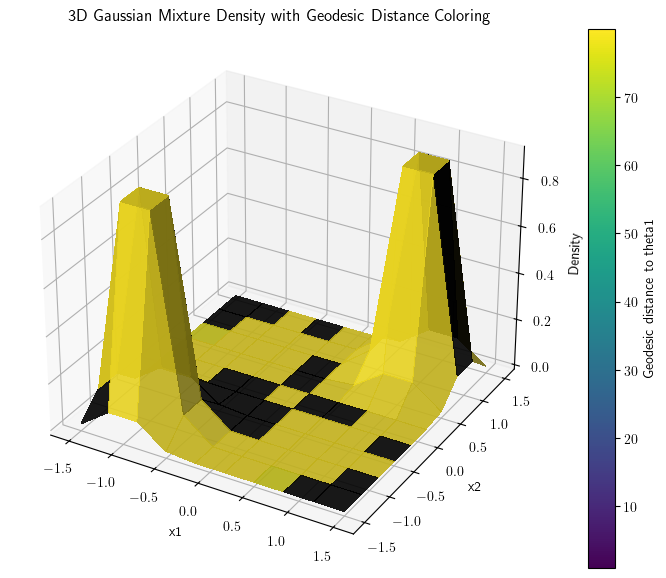

In [10]:
'''
Plot results 
'''
cmap_upper =1
dist_norm = np.clip(distances, 0, cmap_upper) / cmap_upper  # normalize 0..1
#dist_norm =  distances / distances.max()

# --- 3D surface plot ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X1, X2, density.detach().numpy(),
    facecolors=plt.cm.viridis(dist_norm),
    rstride=1, cstride=1, linewidth=0, antialiased=False, alpha=0.9
)

m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
#m.set_clim(0, cmap_upper)           # clip colorbar
m.set_array(distances)              
plt.colorbar(m, ax=ax, label='Geodesic distance to theta1')

# Axis labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Density')
ax.set_title('3D Gaussian Mixture Density with Geodesic Distance Coloring')

plt.show()

# Debugging

all_t [0.99] all_x [[-1. -1.]]
all_t [0.99] all_x [[-1. -1.]]
Energy of pf ode trajectory: 1376118.0
tensor([-4.6136e-07, -4.6136e-07]) tensor([[-1., -1.]])


100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


Energy of the geodesic: 3399854.75


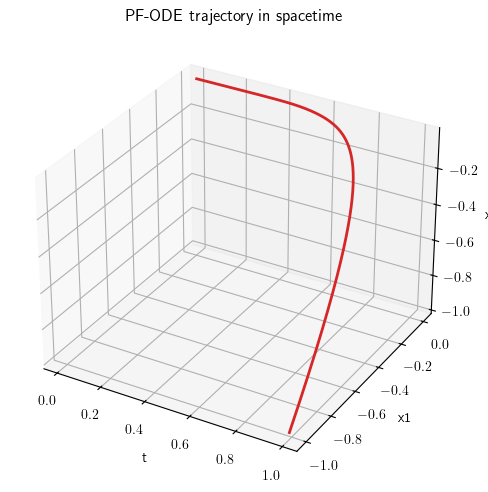

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

theta2 = torch.tensor([[-1, -1]], dtype=torch.float32)
theta2_final = torch.tensor([[1, -1, -1]], dtype=torch.float32)
 
#theta2 = torch.tensor(theta2, dtype=torch.float32)

LAMBDA_MAX, LAMBDA_MIN = 10, -10

original_means = torch.tensor([
    [-1.0, -1.0],  
    [1.0, 1.0]     
], dtype=torch.float32)  
original_variance = torch.tensor(0.00001, dtype=torch.float32)  # isotropic variance
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)      # mixture weights


def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

all_t, all_x = sample(theta2, 2000, t_start=0.99, t_end=0.01)
pf_ode = sample(theta2, 2000, t_start=0.99, t_end=0.01)
t_np = all_t[:, 0]
x1_np = all_x[:, 0, 0]
x2_np = all_x[:, 0, 1]

t_curve = torch.from_numpy(t_np).unsqueeze(1)   # (N, 1)
x_curve = torch.from_numpy(all_x[:, 0, :])      # (N, 2)

pf_ode_theta = torch.cat([t_curve, x_curve], dim=1)
pf_ode_theta = pf_ode_theta.detach().requires_grad_(True)

print('Energy of pf ode trajectory:', energy(pf_ode_theta).item())

print(x_curve[-1], theta2)
# --- Compute geodesic ---
shortest_path12 = geodesic( pf_ode_theta[-1], pf_ode_theta[0],
                           n_opt_steps=100,
                           num_intermediate_points=500,
                           num_nodes=3)


# --- Compute energy ---
energy_val = energy(torch.from_numpy(shortest_path12).float().requires_grad_(True))
print('Energy of the geodesic:', energy_val.item())

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(t_np, x1_np, x2_np, color='C3', linewidth=2)

ax.set_xlabel('t')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.set_title('PF-ODE trajectory in spacetime')

plt.tight_layout()
plt.show()

